<a href="https://colab.research.google.com/github/luffystxr/app/blob/main/Forest_Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-wildfire-dataset


In [35]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [36]:
# TO ensure the GPU is present
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print('GPU is Available!')
else:
  print('GPU is Unavailable!')

GPU is Available!


In [ ]:
#resizing image dataset before training it will save lot of time and space
import os
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

# Set paths
original_base = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version'
resized_base = '/kaggle/working/resized_wildfire_dataset'
target_size = (224, 224)

splits = ['val','test']
classes = ['fire','nofire']

for split in splits:
    for cls in classes:
        input_dir = os.path.join(original_base, split, cls)
        output_dir = os.path.join(resized_base, split, cls)
        os.makedirs(output_dir, exist_ok=True)

        for file in tqdm(os.listdir(input_dir), desc=f'{split}/{cls}'):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(input_dir, file)
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(target_size, Image.Resampling.LANCZOS)
                    img.save(os.path.join(output_dir, file), format='JPEG', quality=90)
                except (UnidentifiedImageError, OSError) as e:
                    print(f"❌ Skipping {file} due to decompression or format error: {e}")


In [37]:
# Load and explore the dataset
train_dir = '/kaggle/working/resized_wildfire_dataset/train'
val_dir = '/kaggle/working/resized_wildfire_dataset/val'
test_dir = '/kaggle/working/resized_wildfire_dataset/test'

In [38]:
# List all the classes
classes = os.listdir(train_dir)
num_classes = len(classes)

# Display the class names
print(f'Number of Classes: {num_classes}')
print(f'Classes: {classes}')

Number of Classes: 2
Classes: ['fire', 'nofire']


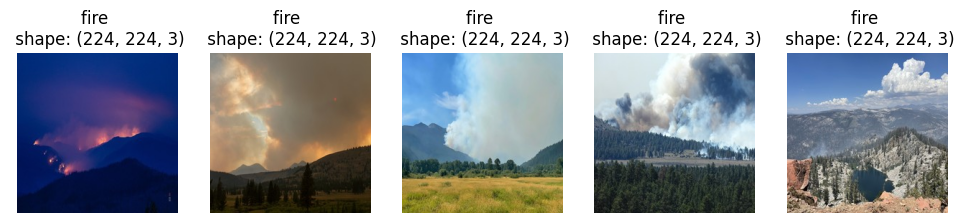

In [39]:
# Let's visualize the images in the dataset
plt.figure(figsize=(12, 10))
for i in range(5):
  class_path = os.path.join(train_dir, classes[0])
  img_name = os.listdir(class_path)[i]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(1, 5, i+1)
  plt.imshow(img)
  plt.title(f'{classes[0]} \n shape: {img.shape}')
  plt.axis('off')
plt.show()

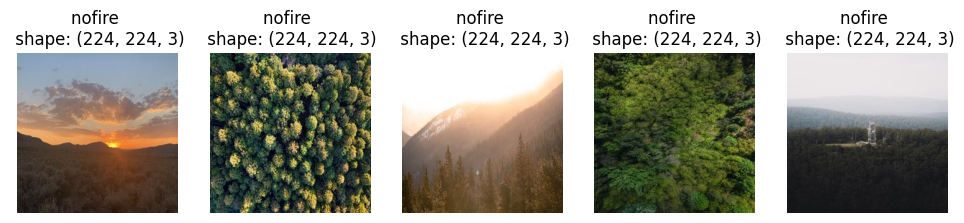

In [40]:
plt.figure(figsize=(12, 10))
for i in range(5):
  class_path = os.path.join(train_dir, classes[1])
  img_name = os.listdir(class_path)[i]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(1, 5, i+1)
  plt.imshow(img)
  plt.title(f'{classes[1]} \n shape: {img.shape}')
  plt.axis('off')
plt.show()

In [42]:
# Preprocessing
# Image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32 # there will be 32 images in a batch!

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [43]:
# map the indices
class_mapping = train_generator.class_indices
# print(class_mapping)
# Extract the class names
class_names = list(class_mapping.keys())
print("Class Names:", class_names)

Class Names: ['fire', 'nofire']


In [57]:
# Let's build the CNN Model
model = Sequential([
    Input(shape=(img_width, img_height, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
]
)


In [58]:
from tensorflow.keras.optimizers import Adam  # ✅ Import this

model.compile(
    optimizer=Adam(learning_rate=1e-4),  # ✅ Use capital A
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
    mode='max'
)


In [61]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 403ms/step - accuracy: 0.7719 - loss: 0.4770 - val_accuracy: 0.7687 - val_loss: 0.4503 - learning_rate: 5.0000e-05
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 391ms/step - accuracy: 0.7689 - loss: 0.4784 - val_accuracy: 0.7388 - val_loss: 0.4653 - learning_rate: 5.0000e-05
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 392ms/step - accuracy: 0.7719 - loss: 0.4741 - val_accuracy: 0.7537 - val_loss: 0.4493 - learning_rate: 5.0000e-05
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 397ms/step - accuracy: 0.7715 - loss: 0.4684 - val_accuracy: 0.7711 - val_loss: 0.4479 - learning_rate: 5.0000e-05
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 397ms/step - accuracy: 0.7900 - loss: 0.4607 - val_accuracy: 0.7836 - val_loss: 0.4295 - learning_rate: 5.0000e-05
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 396ms/step - accuracy: 0.7850 - loss: 0.4546 - val_accuracy: 0.8035 - val_loss: 0.4303 - learning_rate: 5.0000e-05
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 392ms/step - acc

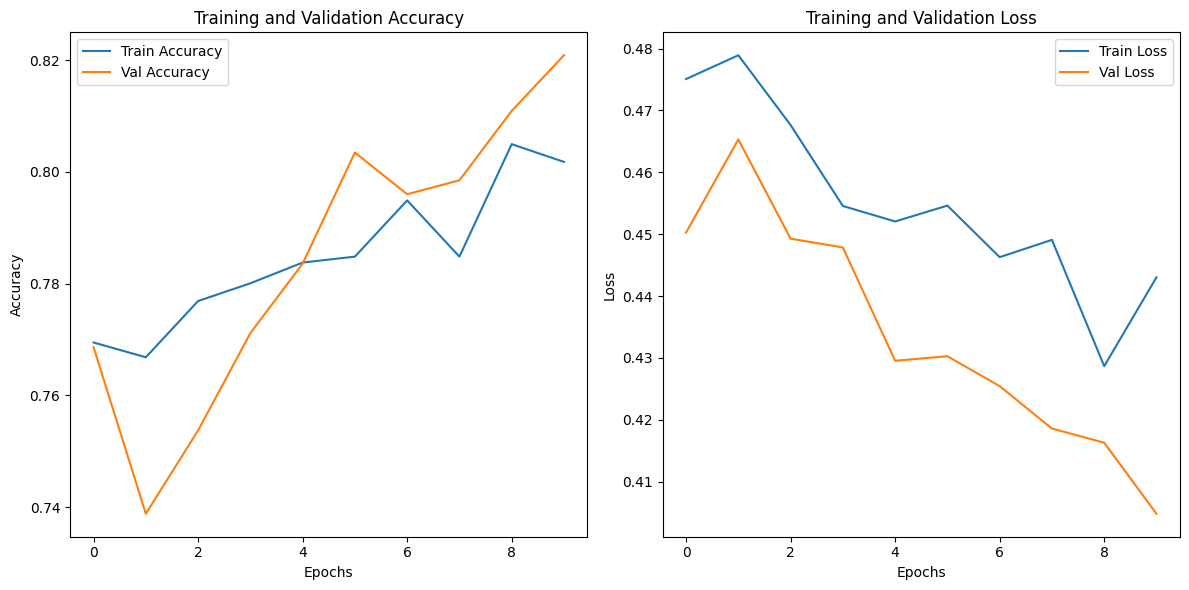

In [62]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()

In [80]:
#Evaluate model using test data
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8311 - loss: 0.3754
Test Accuracy: 0.8341
Test Loss: 0.3805


In [81]:
# Save the model
model.save('FFD.keras')

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os
from PIL import Image  # For displaying original size images

# Load the trained model
model = load_model('FFD.keras')

# Define class names
class_names = ['fire', 'nofire']

# Prediction function (returns original image + predicted class)
def predict_fire(img_path):
    # Load original image for display
    img_original = Image.open(img_path)

    # Load and preprocess image for model prediction
    img = image.load_img(img_path, target_size=(224, 224))  # Resize only for model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_names[1] if prediction[0] > 0.5 else class_names[0]

    return img_original, predicted_class

# Display function with 3 cols × 5 rows layout
def display_images_with_predictions(image_directory, n_images=15):
    file_names = [f for f in os.listdir(image_directory) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    rows, cols = 5, 3  # 5 rows × 3 columns
    plt.figure(figsize=(cols * 6, rows * 5))  # Bigger figure

    for i, img_name in enumerate(file_names[:n_images]):
        img_path = os.path.join(image_directory, img_name)

        try:
            img, predicted_class = predict_fire(img_path)

            ax = plt.subplot(rows, cols, i + 1)
            ax.imshow(img)
            ax.set_title(f'Prediction: {predicted_class}', fontsize=16, fontweight='bold')
            ax.axis('off')
        except Exception as e:
            print(f"Error loading {img_name}: {e}")

    plt.tight_layout(pad=3.0)
    plt.show()

# Example usage
image_directory = '/kaggle/working/resized_wildfire_dataset/test'  # Change if needed
display_images_with_predictions(image_directory)


<Figure size 1800x2500 with 0 Axes>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


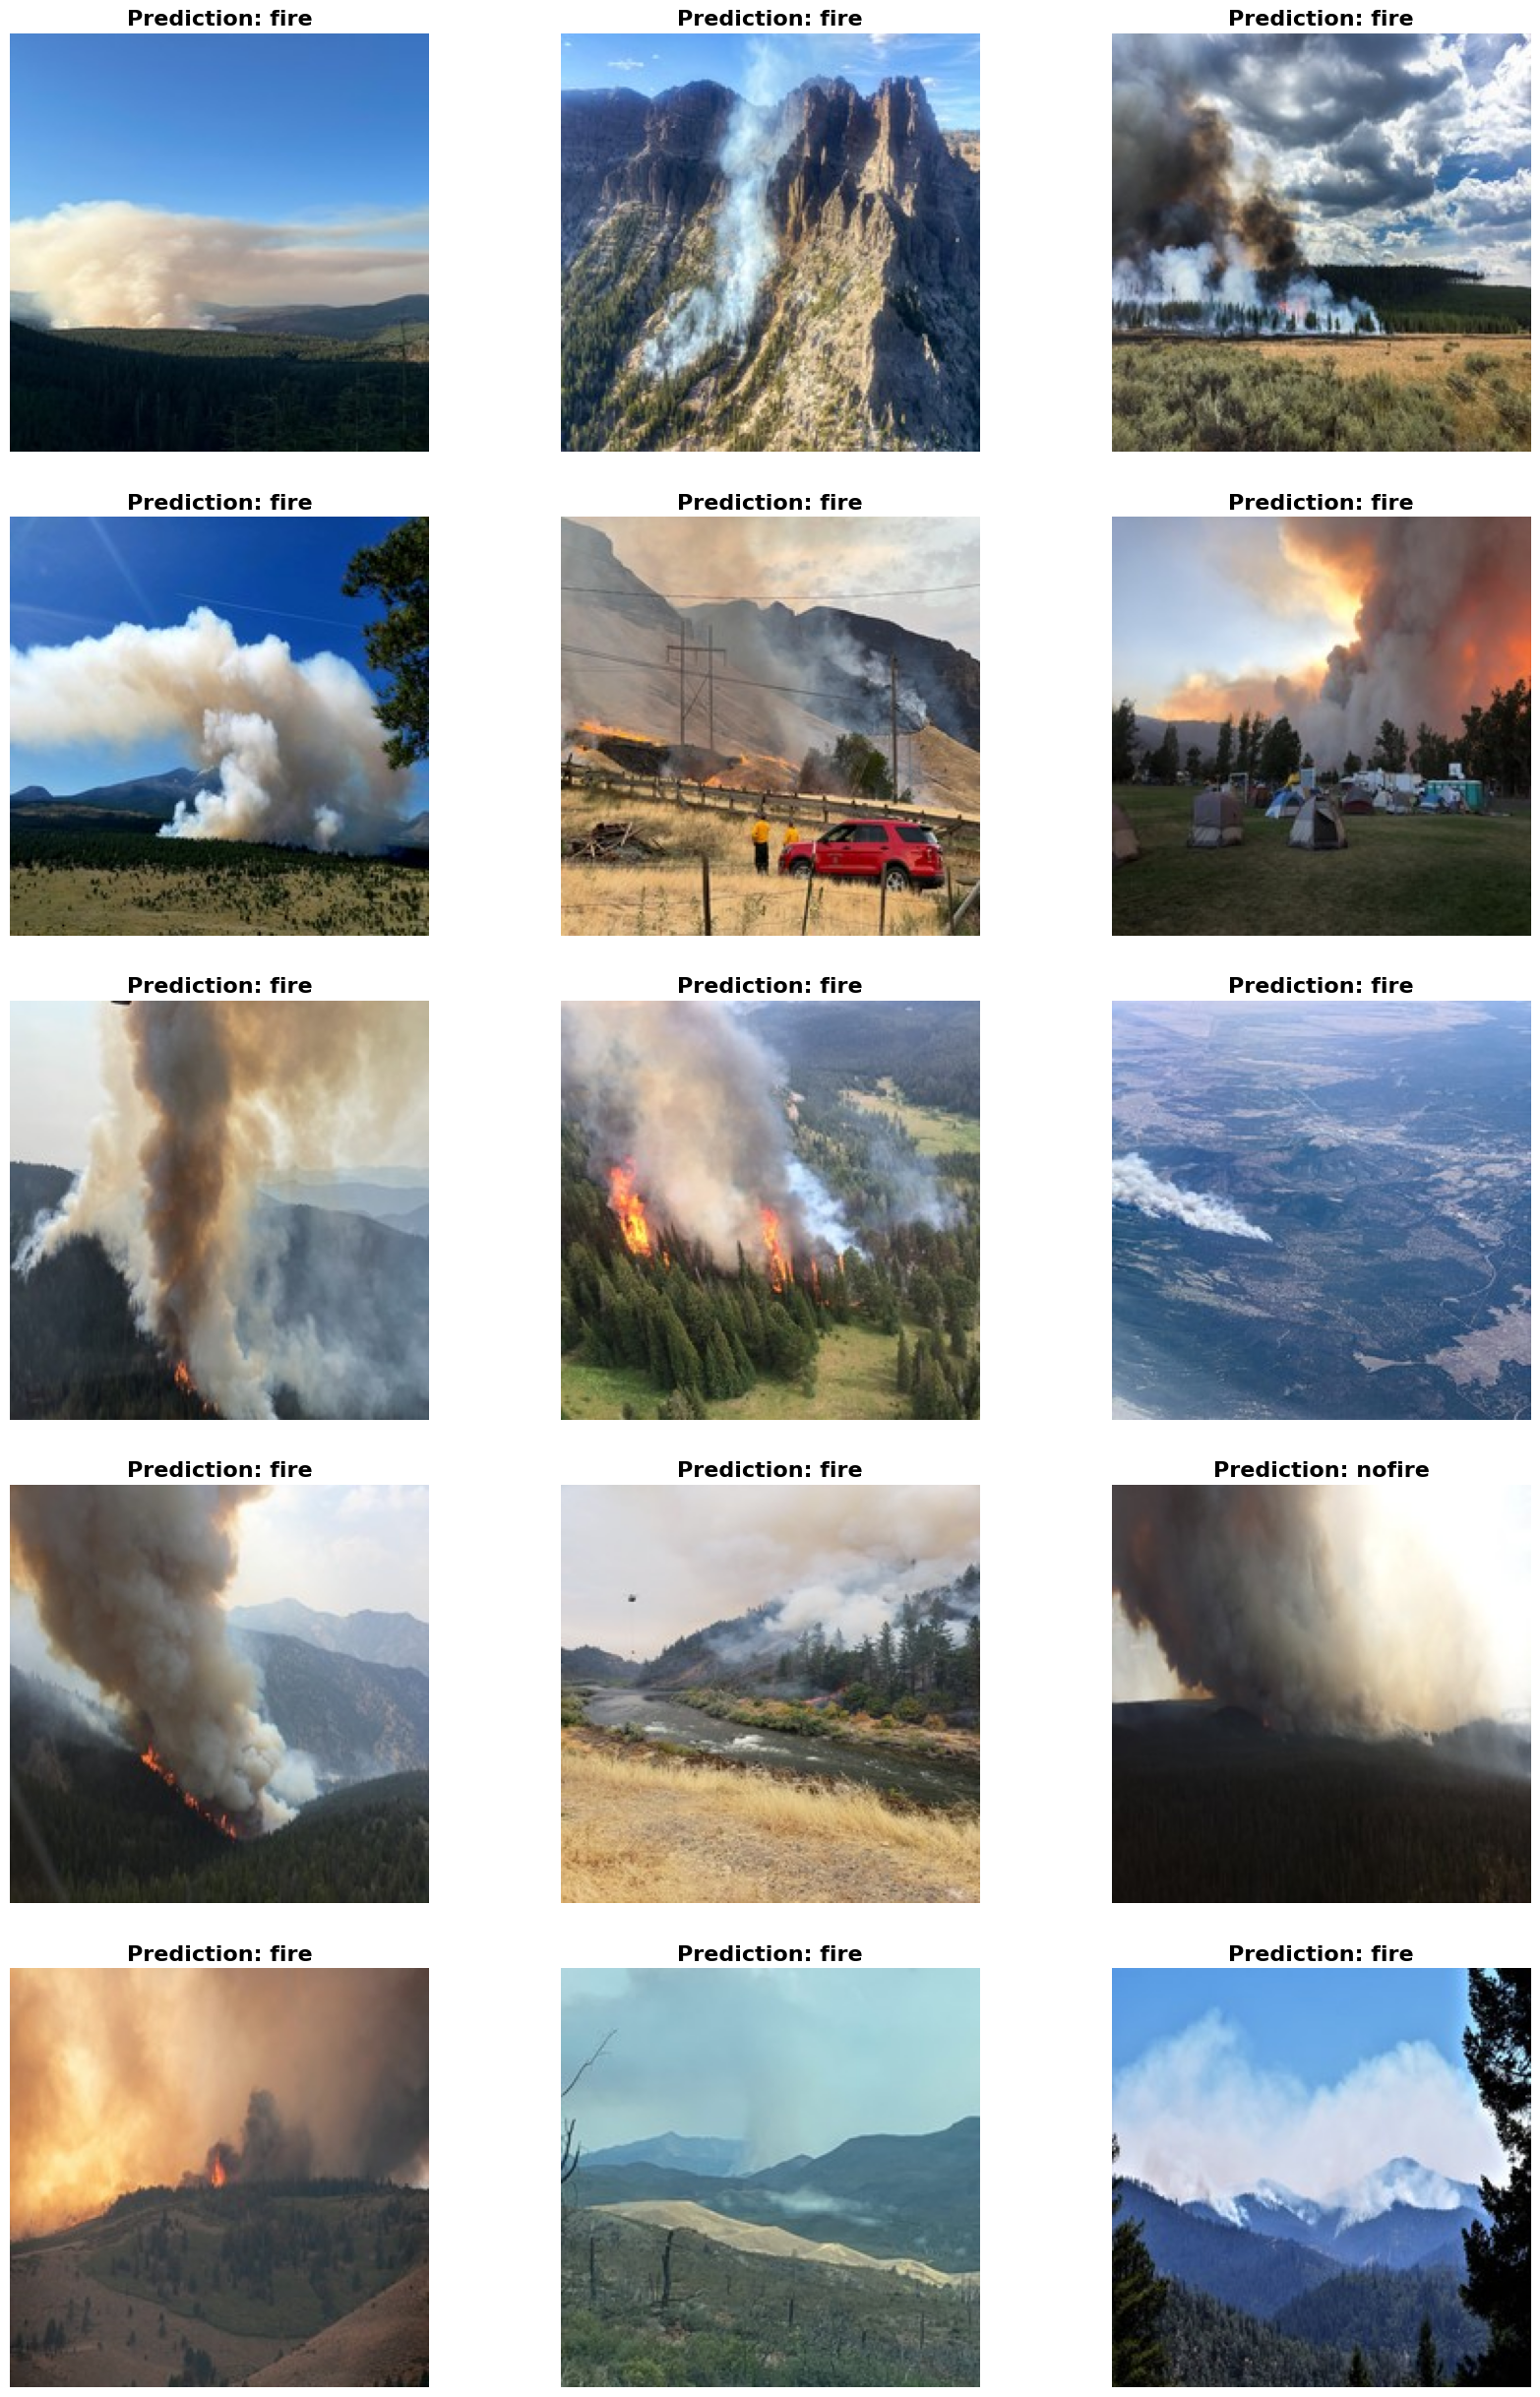

In [88]:
# testing_fire_images
image_directory = '/kaggle/working/resized_wildfire_dataset/test/fire'  # Replace with your directory path
display_images_with_predictions(image_directory)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


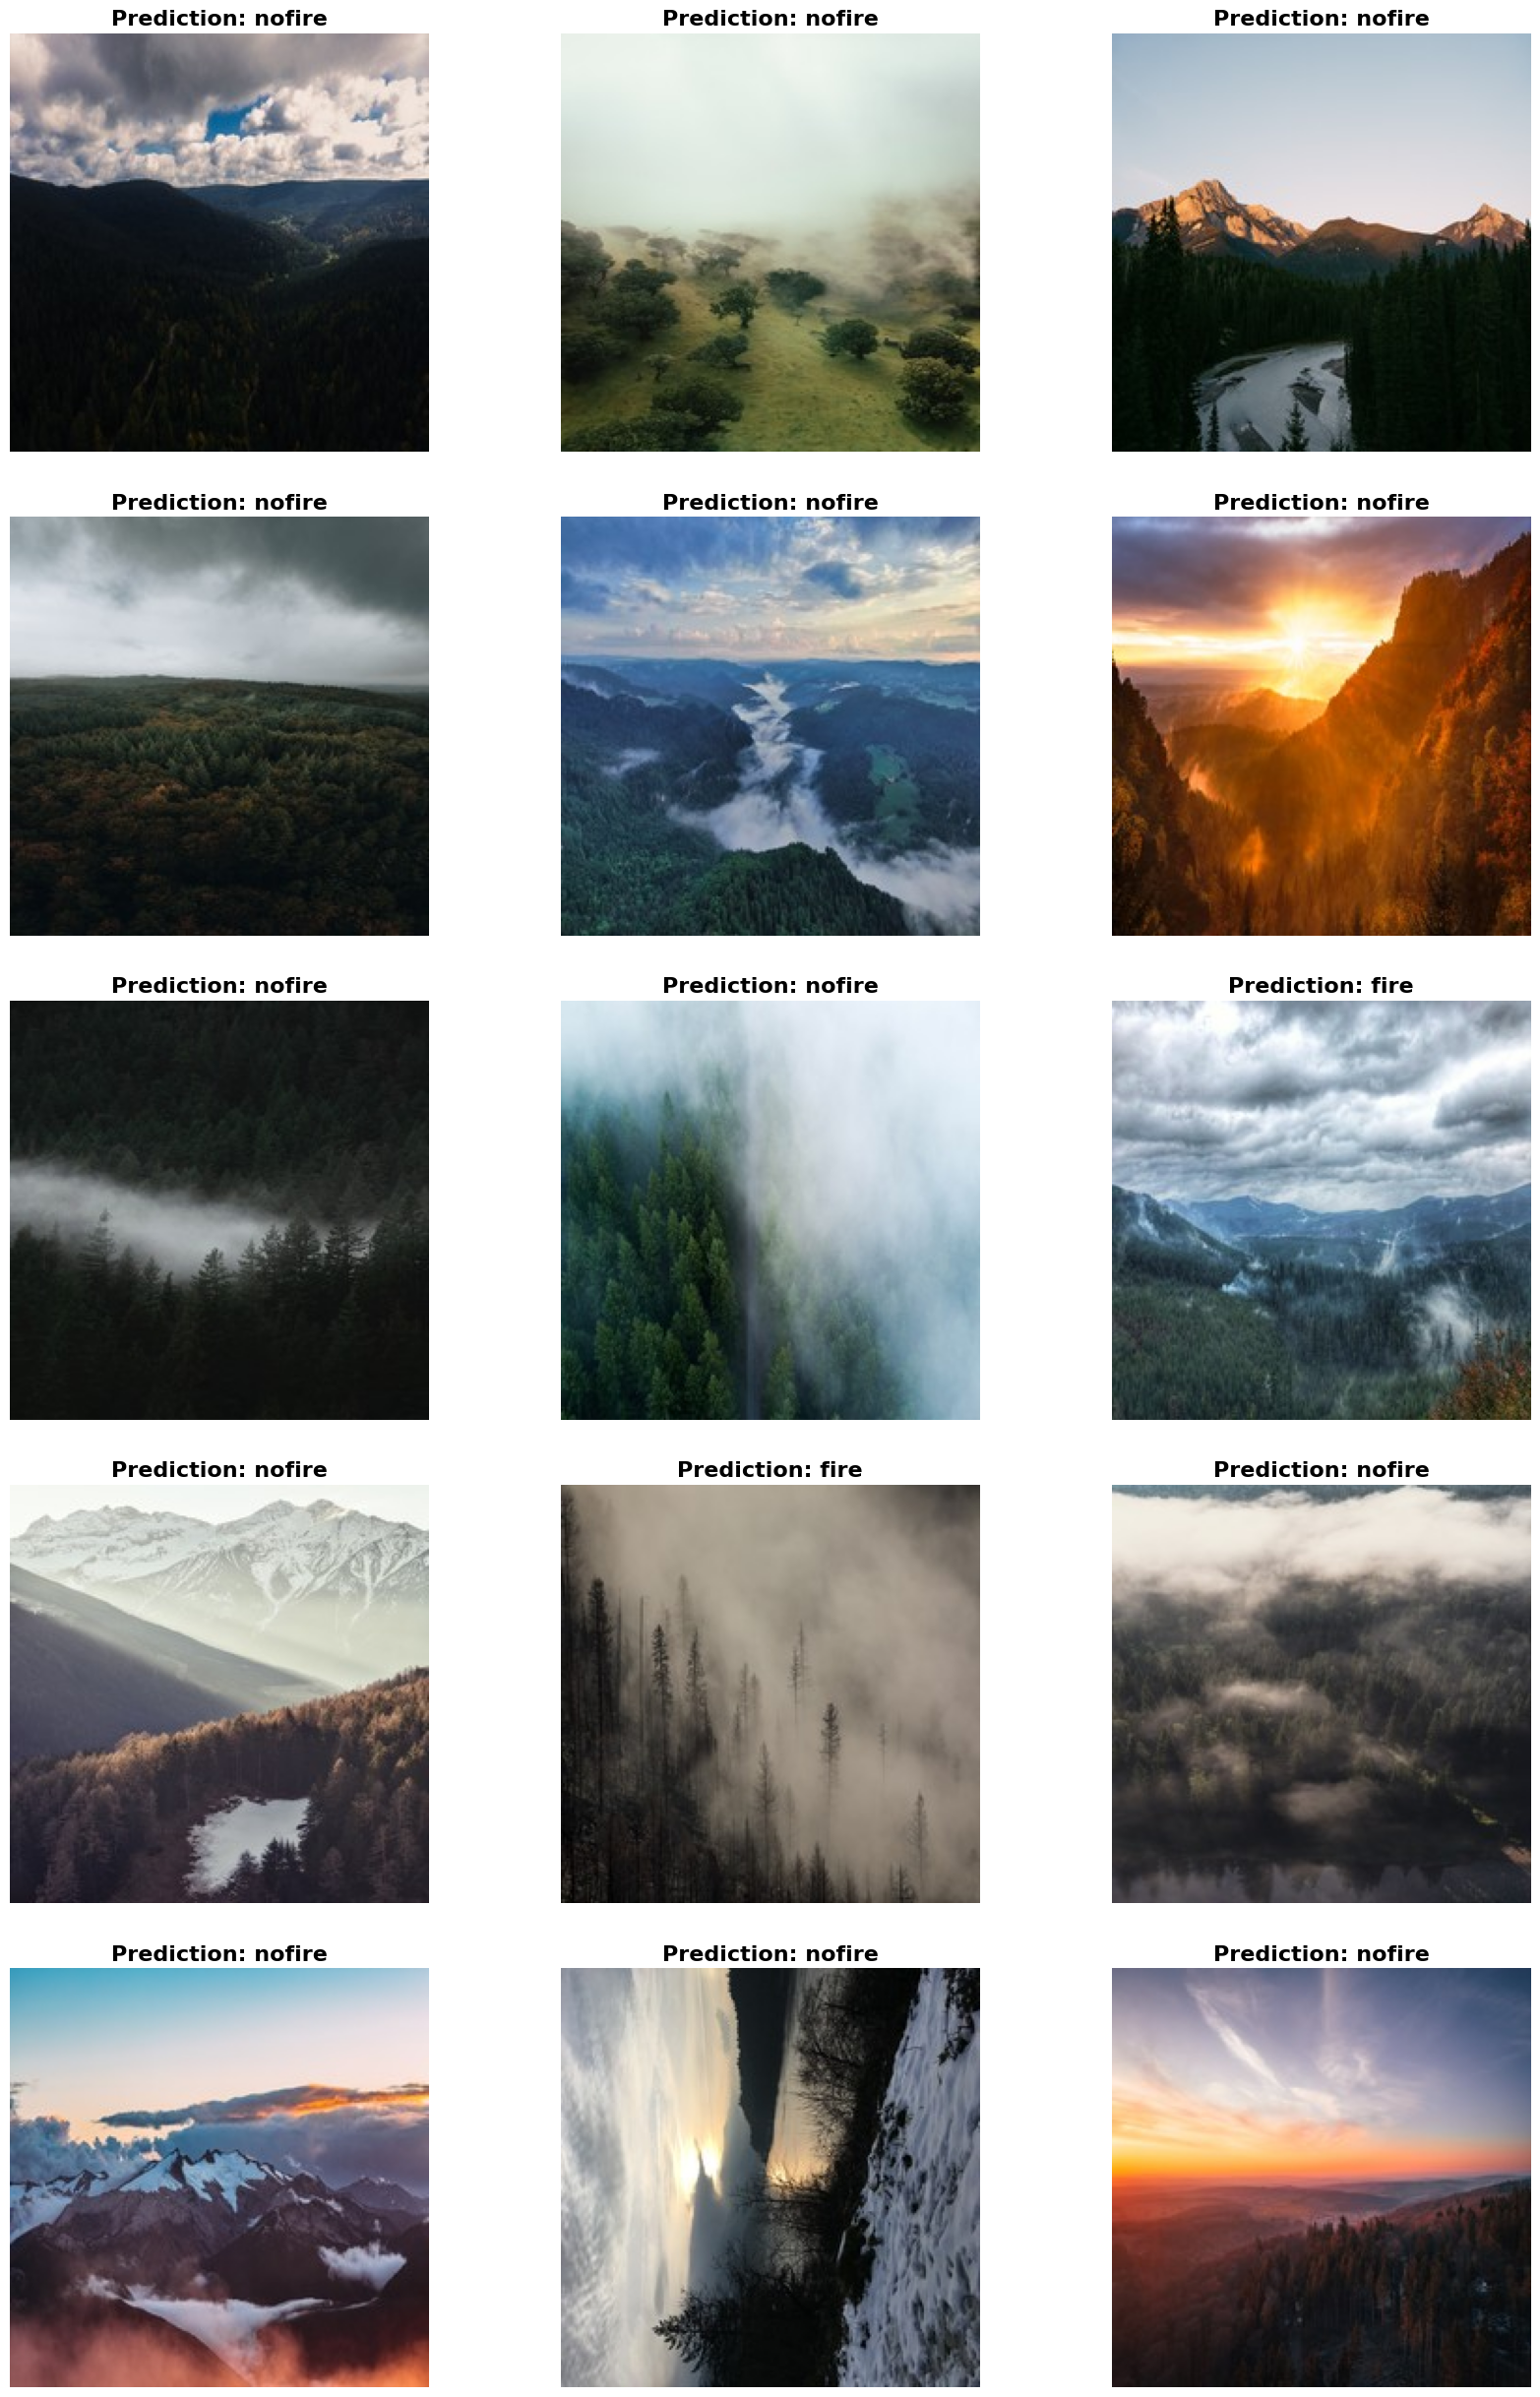

In [89]:
#testing_nofire_images
image_directory = '/kaggle/working/resized_wildfire_dataset/test/nofire'  # Replace with your directory path
display_images_with_predictions(image_directory)

In [106]:
from google.colab import files
files.download('/content/FFD.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>